# Networks - Peer Effects
_02.05.2024_

__Daniel Fisch__

In this notebook, I analyse peer effects on the AddHealth data set. I first look at how the concept of Bonacich centrality and key player are linked and hoe it can help to reduce overall activity on a graph. I then use the graph to create an instrument to estimate the strength of peer effects on the school networks.

# Key Player

Using the Addhealth nomination data, where each student was asked to name their best friends, I compute the interior
solution of the peer effects model by [Calvó-Armengol et al. (2009)](https://docs.iza.org/dp3859.pdf) for some schools and find the key player.

In [1]:
import pyreadr
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse.linalg as sla
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigs
from scipy.sparse import block_diag as block_diag_sparse
from scipy.sparse import eye as eye_sparse
from scipy.linalg import block_diag
from linearmodels.iv import IV2SLS
from tabulate import tabulate

Parameters of the model

In [2]:
alpha = 0.01
beta = 0.1

Read in the data and merge on questionnaire ID

In [3]:
# Read in data and merge to one large data frame
data = pyreadr.read_r('PATH\\AddHealth.RData')

friend = data['friend']
inschool = data['inschool']

friend = pd.DataFrame(friend)
friend = friend[friend['sqid'] != '999999']

inschool = pd.DataFrame(inschool)
inschool = inschool[inschool['sqid'] != '999999']

# Create a vector of the relevant columns for the network relations
cols = friend.columns
cols = cols[1:]

df = friend.merge(inschool, on='sqid', how='right')

,sqid,mf1aid,mf2aid,mf3aid,mf4aid,mf5aid,ff1aid,ff2aid,ff3aid,ff4aid,...,s44a29,s44a30,s44a31,s44a32,s44a33,s6a,s6b,s6c,s6d,s6e
0,100002,97500917,91540116,92570711,94500610,99540111,96570918,97540313,93570913,92570017,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,100003,98570915,98500010,98540216,99999999,93570210,91570318,93540919,94540319,93540318,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,100005,96714212,93714917,97714019,96714011,98714911,96714116,92714919,95714915,96714217,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,100008,99570318,96570714,98570011,94570112,NaN,99500711,90500617,92540913,93570717,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,100009,99999999,NaN,NaN,NaN,NaN,77777777,98570013,97500417,90570112,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89935,539914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
89936,546404,NaN,NaN,NaN,NaN,NaN,92710294,77777777,77777777,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
89937,678452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
89938,732172,94676521,91606020,96606828,94606026,94606521,94606827,99999999,88888888,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Make data more readable
df.rename(columns={'aid': 'id', 'sschlcde': 'school'}, inplace=True)
df.sort_values(by='school', inplace=True)

# Data cleaning (replace 777... and 888... with NaN and drop all rows with an empty id number)
df.replace([77777777, 88888888, 99999999], pd.NA, inplace=True)
df.drop(df[df['id'] == ''].index, inplace=True)

df[cols] = df[cols].astype('Int64')
df['id'] = df['id'].astype('Int64')
#df.set_index('id', inplace=True, drop=False)

# Create list of unique school IDs
schools = df['school'].unique()

,sqid,mf1aid,mf2aid,mf3aid,mf4aid,mf5aid,ff1aid,ff2aid,ff3aid,ff4aid,...,s44a29,s44a30,s44a31,s44a32,s44a33,s6a,s6b,s6c,s6d,s6e
87355,276489,94579955,93579956,90579956,<NA>,<NA>,91579255,96579953,<NA>,97579952,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
27855,158368,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3473,106687,94579955,<NA>,<NA>,<NA>,<NA>,93579953,96579955,91579258,<NA>,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3471,106685,92579959,96579956,97579953,98579959,95579950,98579957,<NA>,<NA>,<NA>,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
87425,276625,94579956,97579958,96579259,96579253,94579957,95579953,94579950,98579956,93579951,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83120,267237,<NA>,90316555,92316152,<NA>,<NA>,98316256,90316050,93316458,93316258,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83121,267238,97316456,98316150,93316156,96316852,<NA>,<NA>,<NA>,<NA>,<NA>,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
83122,267239,<NA>,<NA>,<NA>,93316554,99316556,90316559,94316659,96316554,98316451,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
83116,267233,95316856,95316951,92316658,97316557,95316059,<NA>,95316352,99316650,96316557,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0


### Functions

In [5]:
'''
Creates undirected graph per school from data frame containing friend nominations 
'''
def create_graph(df, school):
    df_school = df[df['school'] == school]
    # Create an undirected graph
    G = nx.Graph()
    # make sure graphs are in the right node order to match X-matrix when estimating peer effects
    G.add_nodes_from(df_school['id'])  
    # Iterate over rows and add edges based on conditions
    for _, row in df_school.iterrows():
        source_node = row['id']
        target_nodes = row[['mf1aid', 'mf2aid', 'mf3aid', 'mf4aid', 'mf5aid', 'ff1aid', 'ff2aid', 'ff3aid', 'ff4aid', 'ff5aid']]
        for target_node in target_nodes:
            if not pd.isnull(target_node) and source_node != target_node: # exclude self-loops
                # excluding the self loops significantly changes some actions on networks
                # from question not clear whether self-loops are intended
                G.add_edge(source_node, target_node)
                
    return G

'''
Calculates giant component from networkx graph G and returns the subgraph
'''
def giant_component(G, sort = False):
    # Check that graph reasonably
    if len(G.nodes) == 0 or len(G.edges) == 0:
        print("Warning: empty/disconnected graph")
        return None
    # Find the largest connected component
    largest_cc_nodes = max(list(nx.connected_components(G)), key=len)
    # Create a subgraph of only the largest connected component
    GC = G.subgraph(largest_cc_nodes).copy()
    
    if sort:
        # Sort the nodes
        sorted_nodes = sorted(GC.nodes())
        # Create a new graph with sorted nodes
        sorted_GC = nx.Graph()
        sorted_GC.add_nodes_from(sorted_nodes)
        sorted_GC.add_edges_from(GC.edges())
        
        return sorted_GC
    else:
        return GC
'''
Calculate interior solution activity
'''
def int_sol(G):
    A = nx.to_numpy_array(G) # assume A symmetric (undirected graph)
    n = G.number_of_nodes()
    B = np.linalg.inv(np.eye(n) - beta * A).dot(np.ones(n)) # note, this is NOT Bonacich
    return alpha*B
'''
Calculates Bonacich centrality
'''
def bonacich(G):
    A = nx.to_numpy_array(G) # assume A symmetric (undirected graph)
    n = G.number_of_nodes()
    b = beta * np.dot(A, np.ones(n)) 
    B = np.linalg.inv(np.eye(n) - beta * A).dot(b)
    return B
'''
Calculate key player using geometric series formula
'''
def key_player(G):
    B = bonacich(G)
    A = nx.to_numpy_array(G)
    n = G.number_of_nodes()
    
    # Assume that already convergence property checked
    m = np.linalg.inv(np.eye(n) - beta * A)

    # find argmax
    values = B**2 / np.diag(m)
    argmax = np.argmax(values)
    return list(G.nodes)[argmax]
'''
Calculate key player using brute force calculation
'''
def key_player_manual(G):
    # Compute baseline Bonacich Centrality
    bc = bonacich(G).sum()

    # Keep track
    max_reduction = float('-inf')
    min_activity = float('inf')
    node_ = None
    
    # Calculate Bonacich centrality for any node removed
    for node in G.nodes():
        G_ = G.copy()
        G_.remove_node(node)
        bc_ = bonacich(G_).sum() 
        reduction = (bc - bc_)
        if reduction > max_reduction:
            node_ = node
            max_reduction = reduction
            min_activity = alpha*bc_
    return node_

### Eigenvalues etc.

The code answers the following questions:
a) It first generates a graph (create_graph). It then keeps only the largest component (giant_component).

b) Then it calculates for each school the largest in magnitude eigenvalue and continue only with schools for whhich beta < 1/largest e.v. (since only then solution guaranteed to exist). Here several versions are implemented and a sparse algorithm used as it yields (almost, but negligible) the same result but with a significantly reduced running time.

c) For the subselection of schools, calculate the Bonacich centrality $B = \beta (I-\beta A)^{-1} A \,\underline{1}$.

d) And calculate the interior solution for the action and aggregate by summation.

In [6]:
x = {}
B = {}
sel_school = []
for school in schools:
    """a"""
    # Create graph
    G = create_graph(df, school)
    
    """b"""
    # Find its giant component
    GC = giant_component(G)
    
    # Extract adjacency matrix 
    A = nx.to_numpy_array(GC)
    
    # Non-sparse - about same result
    # eigenvalues = np.linalg.eigvals(A)
    # rho = np.max(np.abs(eigenvalues))
     
    # Sparse 1
    #rho = np.abs(sla.eigs(A, k=1, which='LM', return_eigenvectors=False))[0]
    
    # Sparse 2
    A_sparse = csr_matrix(A)
    
    # Calculate eigenvalues using scipy.sparse.linalg.eigs
    num_eigenvalues = 1
    eigenvalue_sparse = eigs(A_sparse, k=num_eigenvalues)[0]
    rho = abs(eigenvalue_sparse[0].real)
    
    
    if beta < 1/rho: 
        # Print the largest eigenvalue
        print("School", school, ":", rho)
        
        '''c'''
        # Compute Bonacich Centrality
        B_val = bonacich(GC)
        
        '''d'''
        # Compute interior solution
        x_val = int_sol(GC)
        
        # Store results
        x[school] = x_val.sum()
        B[school] = B_val
        
        # Store the schools which fulfill the EV condition
        sel_school.append(school)
    else:
        print("NOT school", school)
    print(len(G.nodes), "-", len(GC.nodes))

x = pd.Series(x)

School 001 : 7.318881196379233
58 - 56


School 002 : 8.720875026348798
84 - 82
NOT school 003
179 - 171
School 004 : 8.177389763397493
43 - 43
NOT school 006
266 - 255
NOT school 007
203 - 199
NOT school 008
146 - 136
NOT school 009
392 - 376
NOT school 010
312 - 306
NOT school 012
306 - 298
NOT school 013
854 - 844
NOT school 014
363 - 350
NOT school 015
651 - 643
NOT school 016
527 - 496
NOT school 017
427 - 421
NOT school 018
831 - 813
NOT school 019
616 - 600
NOT school 020
1065 - 1037
NOT school 021
439 - 434
NOT school 022
485 - 479
NOT school 023
744 - 740
NOT school 024
458 - 455
NOT school 025
720 - 701
NOT school 026
682 - 670
NOT school 027
481 - 469
School 028 : 8.707279079167607
182 - 178
NOT school 029
963 - 928
NOT school 030
655 - 641
School 031 : 6.696083767669108
1364 - 1286
NOT school 033
1064 - 1036
NOT school 034
716 - 704
NOT school 035
918 - 886
School 039 : 8.977092603621966
631 - 497
NOT school 040
1143 - 1115
School 041 : 9.626262189144276
3031 - 2695
NOT school 042
1468 - 1394
NOT school 043
802 - 

In [7]:
# When allowing for self loops, only 34 graphs are selected
len(x)

36

## Aggregate activity normalized by school size

Proxy for school size: respondants per school (not necessarily same as number nodes)

In [8]:
# Calculate proxy for school size by number of respondants to survey 
# (after data cleaning, i.e. dropping missing aid cells)
schools_no = df['school'].value_counts()

agg_act = x/schools_no
agg_act

001    0.050370
002    0.069468
003         NaN
004    0.044979
006         NaN
         ...   
269         NaN
270         NaN
271    0.027887
369         NaN
371    0.285652
Length: 142, dtype: float64

Generate a histogram of the aggregate activity

This histogram looks very different when allowing for self-loops


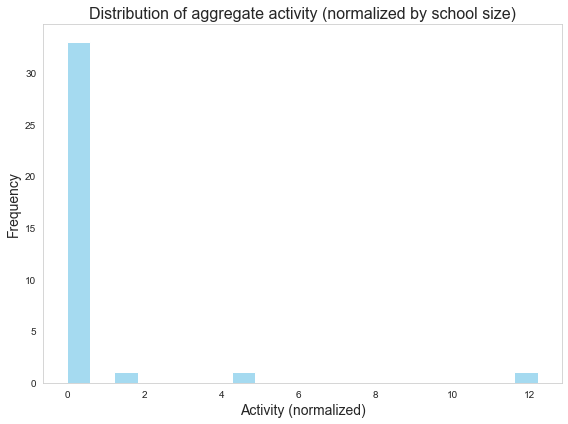

In [9]:
# Generate a histogram of total activity (sum of individual interior solutions) 
# normalized by school size proxy of number of respondants per school
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))  

sns.histplot(agg_act, color='skyblue', bins=20, kde = False)

plt.xlabel('Activity (normalized)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of aggregate activity (normalized by school size)', fontsize=16)
plt.grid(None)

plt.tight_layout()  
#plt.savefig('histogram.png', dpi=300) 
print("This histogram looks very different when allowing for self-loops")
plt.show()

e) find the school with median activity and plot its network

In [10]:
sorted_act = agg_act.sort_values()
sorted_act.dropna(inplace=True)

median_index = len(sorted_act) // 2
sorted_act.iloc[median_index-2:median_index+2]

092    0.051014
168    0.051087
139    0.051437
173    0.056639
dtype: float64

In [11]:
# Calculate the median of the Series
median_value = agg_act.median()

# Find the index
median_index = agg_act.sub(median_value).abs().idxmin()

print(median_index,":", agg_act[median_index],"- vs. median :", median_value) 
# not exact for even number of observations

139 : 0.05143710467219653 - vs. median : 0.05126185724932857


In [12]:
# by even number, can choose either upper/lower value
median_index = '139'#'168'

In [13]:
G = create_graph(df, median_index)
G = giant_component(G)

# Find highest Bonacich node
max_ind = np.argmax(B[median_index])
node_to_color = list(G.nodes())[max_ind]

print("Most Bonacich central node:",node_to_color)
(np.max(B[median_index]), B[median_index][max_ind]) #check

Most Bonacich central node: 92711979


(50.83051083538152, 50.83051083538152)

Two plots: one with the Bonacich centrality as numeric value. However, since it is not very readable for such a large network, the second plot is colourcoded where red corresponds to a very high centrality, green a medium, blue and then violet for a low centrality

__With__ key player

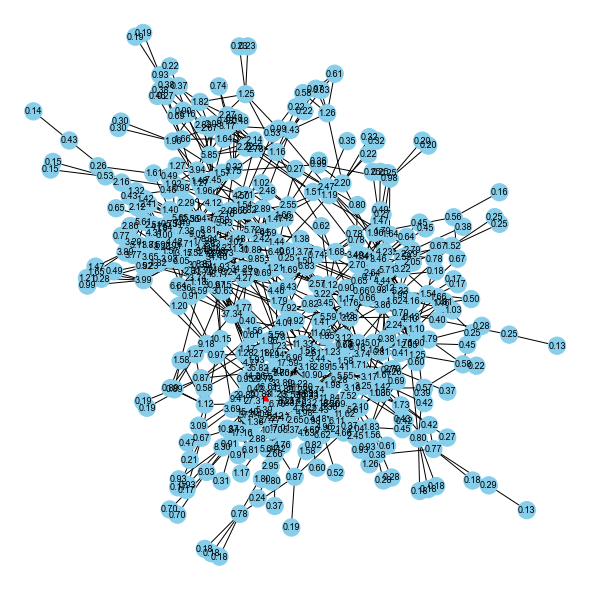

In [14]:
plt.figure(figsize=(8, 8))

# Draw the graph
pos = nx.spring_layout(G, seed= 42) # nx.kamada_kawai_layout(G, scale=3) 
#nx.draw(G, pos, with_labels=False, node_size=250, node_color='skyblue')
nx.draw(G, pos, with_labels=False, node_size=[400 if node == node_to_color else 300 for node in G.nodes()], node_color=['red' if node == node_to_color else 'skyblue' for node in G.nodes()])

# Add node labels rounded to two digits from the array 'B'
labels = {node: f"{B[median_index][i]:.2f}" for i,node in enumerate(G.nodes())}
nx.draw_networkx_labels(G, pos, labels, font_color='black', font_size=9)

plt.axis('off')
plt.margins(0)
plt.show()

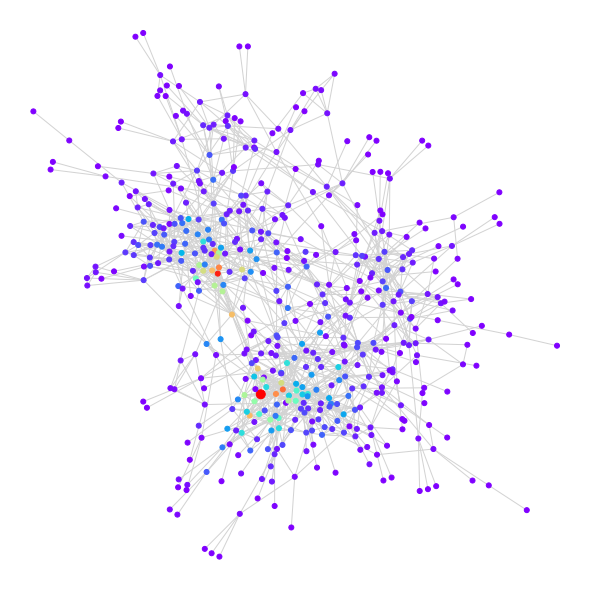

In [15]:
plt.figure(figsize=(8, 8))

# Draw the graph
pos = nx.spring_layout(G, seed=42)

# Color code the nodes based on their B[median_index] value
node_colors = [B[median_index][i] for i, node in enumerate(G.nodes())]
vmin=min(node_colors)
vmax=max(node_colors)
# Draw nodes with color coding
nx.draw(G, pos, with_labels=False, node_size=[80 if node == node_to_color else 25 for node in G.nodes()], node_color=node_colors, cmap=plt.cm.rainbow, edge_color='lightgray')

# Add node labels rounded to two digits from the array 'B'
#labels = {node: f"{B[median_index][i]:.2f}" for i, node in enumerate(G.nodes())}
#nx.draw_networkx_labels(G, pos, labels, font_color='black', font_size=9)

plt.axis('off')
plt.margins(0)
plt.show()

f) Finding key player and calculating the reduction in (total/normalized) activity

In [16]:
# Calculate key player
node_ = key_player(G)

# Remove the key player
G_ = G.copy()
G_.remove_node(node_)

# Calculate aggregate activity before and after removing the key player
x_before = int_sol(G)
x_after = int_sol(G_)
B_ = bonacich(G_)
reduction = x_before.sum()- x_after.sum()

print("Node with maximum reduction (key player):", node_, "- with a reduction of", reduction, "in total activity")

Node with maximum reduction (key player): 92711979 - with a reduction of 9.251237324581531 in total activity


__without__ key player

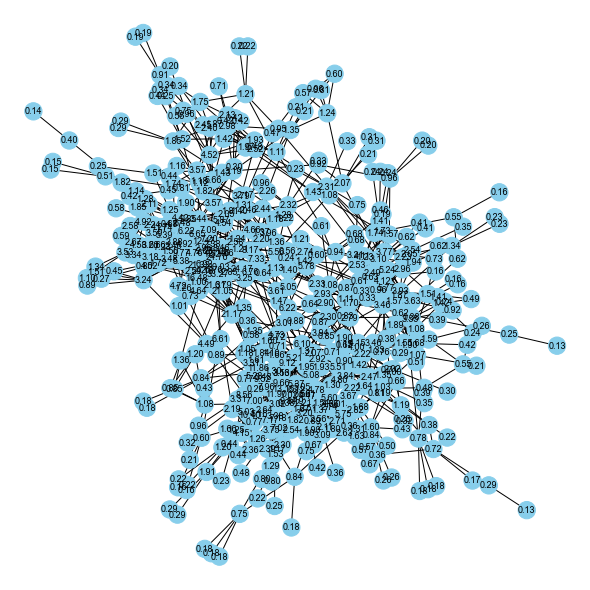

Normalized level before: 0.05143710467219653 - after: 0.034431153707892244
i.e. a normalized reduction of: 0.017005950964304285


In [17]:
plt.figure(figsize=(8, 8))

# Draw the graph
#pos = nx.spring_layout(G_, seed= 42)#nx.kamada_kawai_layout(G_, scale=3) 
nx.draw(G_, pos, with_labels=False, node_size=[400 if node == node_to_color else 300 for node in G_.nodes()], node_color=['red' if node == node_to_color else 'skyblue' for node in G_.nodes()])

# Add node labels rounded to two digits from the array 'B'
labels = {node: f"{B_[i]:.2f}" for i,node in enumerate(G_.nodes())}
nx.draw_networkx_labels(G_, pos, labels, font_color='black', font_size=9)

plt.axis('off')
plt.margins(0)
plt.show()

print("Normalized level before:",x_before.sum()/schools_no[median_index],"- after:",x_after.sum()/schools_no[median_index])
print("i.e. a normalized reduction of:", reduction/schools_no[median_index])

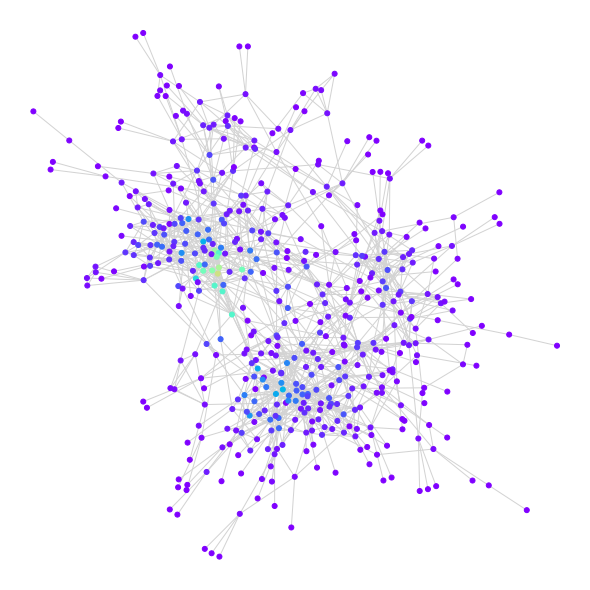

In [18]:
plt.figure(figsize=(8, 8))

# Draw the graph
#pos = nx.spring_layout(G, seed=42)

# Color code the nodes based on their B[median_index] value
node_colors = [B_[i] for i, node in enumerate(G_.nodes())]

# Draw nodes with color coding
nx.draw(G_, pos, with_labels=False, node_size=[80 if node == node_to_color else 25 for node in G_.nodes()], node_color=node_colors, cmap=plt.cm.rainbow, edge_color='lightgray', vmin=vmin, vmax=vmax)

# Add node labels rounded to two digits from the array 'B'
#labels = {node: f"{B[median_index][i]:.2f}" for i, node in enumerate(G.nodes())}
#nx.draw_networkx_labels(G, pos, labels, font_color='black', font_size=9)

plt.axis('off')
plt.margins(0)
plt.show()

Hence, the most Bonacich central node (larger) has been removed. However when selecting '092' which can be chosen as the median school when allowing for self-loops, the most Bonacich central node is NOT the one to remove.

# Estimating peer effect

Rather than simply assuming a parameter $\beta = 0.1$ (as in the previous question) I estimate the strength of peer effects directly from the data, using the 2SLS estimator from [Bramoullé et al. (2009)](https://www.sciencedirect.com/science/article/pii/S0304407609000335).

In [19]:
df2 = df.copy()
df2.sort_values(by='id', inplace=True)

### Create a count of number of societies

<Axes: >

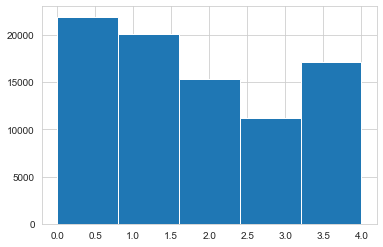

In [20]:
# Create a vector of all possible societies a student can participate in
socs = [f"s44a{i}" for i in range(1, 34)]

# Count the number of societies (and cap at 4)
df2['socs'] = df2[socs].sum(axis=1)
df2['socs'] = df2['socs'].clip(upper=4)

# Plot histogram of society participation as check
df2.socs.hist(bins=5)

## b) Point identification

Handle NAs in questionnaire answers: since dropping still keeps 93% of the data, just drop ppl who did not answer the questionnaire. 

In [21]:
X_col = ['s1', 's2', 's12', 's18', 's6a', 's6b', 's6c', 's6d', 's6e']

print("Questions with NAs:",df2[X_col].columns[df2[X_col].isna().sum()>0])

# Var 1: since it doesnt make too much sense to put mean into yes/no answers, just assume that NA is no
# df2[X_col] = df2[X_col].fillna(0) 

# Var 2: Drop NAs in questionnaire
df2 = df2.dropna(subset=X_col)
# not loosing too many entries, hence choose this NA handling for simplicity

df.shape, df2.shape, df2.shape[0]/df.shape[0]

Questions with NAs: Index(['s1', 's2', 's12', 's18'], dtype='object')


((85627, 55), (79434, 56), 0.9276746820512222)

Workaround to make the network the same size as our feature matrix: remove all friends about which we do not have any information (not answered questionnaire) and only then create the network.

In [22]:
ids=df2['id'].unique()
for col in cols:
    df2[col] = df2[col].mask(~(df2[col].isin(ids)), pd.NA)

In [23]:
df2.isnull().sum()

sqid          0
mf1aid    49360
mf2aid    46930
mf3aid    49446
mf4aid    52981
mf5aid    56472
ff1aid    44116
ff2aid    43086
ff3aid    45911
ff4aid    49838
ff5aid    54011
id            0
school        0
s1            0
s2            0
s12           0
s18           0
s44a1         0
s44a2         0
s44a3         0
s44a4         0
s44a5         0
s44a6         0
s44a7         0
s44a8         0
s44a9         0
s44a10        0
s44a11        0
s44a12        0
s44a13        0
s44a14        0
s44a15        0
s44a16        0
s44a17        0
s44a18        0
s44a19        0
s44a20        0
s44a21        0
s44a22        0
s44a23        0
s44a24        0
s44a25        0
s44a26        0
s44a27        0
s44a28        0
s44a29        0
s44a30        0
s44a31        0
s44a32        0
s44a33        0
s6a           0
s6b           0
s6c           0
s6d           0
s6e           0
socs          0
dtype: int64

Create graph for median school. Choose 139, not 168 (recall, choice because even number)

In [24]:
school = '139'#'168'# '092' #median_index

G = create_graph(df2, school)
GC = giant_component(G)

print("Number nodes:", GC.number_of_nodes())
print("Number edges:", GC.number_of_edges())
print("Comparing size cleaned school giant component w. full original network:", len(list(GC.nodes())), df[df['school']==school].shape[0])

Number nodes: 310
Number edges: 687
Comparing size cleaned school giant component w. full original network: 310 544


In [25]:
def lin_ind(*args):
    # Flatten each matrix into vectors
    flattened_matrices = [matrix.flatten() for matrix in args]
    
    # Concatenate the flattened vectors horizontally
    matrix = np.vstack(flattened_matrices)
    
    # Check the rank of the concatenated matrix
    rank = np.linalg.matrix_rank(matrix)
    
    # Determine if the matrices are linearly independent
    if rank == len(args):
        return True
    else:
        return False

A = nx.to_numpy_array(GC)

I = np.eye(len(A))
A2 = A.dot(A)
A3 = A2.dot(A)

# Check if matrices are linearly independent
result = lin_ind(I, A, A2)
print("Matrices I, A, and A^2 are linearly independent:", result)
print("Assume neither beta = 0 nor gamma = 0")

Matrices I, A, and A^2 are linearly independent: True
Assume neither beta = 0 nor gamma = 0


Since they are linearly independent and we assume gamma is not zero for all entries GX as an instrument allows for point identification - if additionaly beta is also non-zero, all higher order G^kX can also be used for point identification (can also check the graph below and recognize that there are intransitive triads).

Check: nodes colored in red have answered the questionnaire

Fraction of nodes with data: 1.0


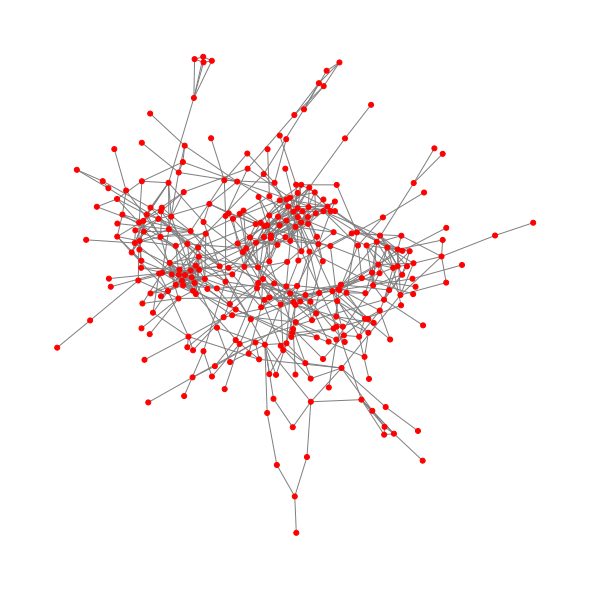

In [26]:
plt.figure(figsize=(8, 8))
nodes_to_color_red = [node for node in GC.nodes() if node in ids]

pos = nx.spring_layout(GC, seed= 42) # nx.kamada_kawai_layout(G, scale=3) 
#nx.draw(GC, pos, with_labels=False, node_size=25, edge_color='gray')
nx.draw(GC, pos, with_labels=False, node_size=25, node_color=['r' if node in nodes_to_color_red else 'b' for node in GC.nodes()], edge_color='gray')

print("Fraction of nodes with data:",len(nodes_to_color_red)/len(list(GC.nodes())))
plt.show()

## c) Create vector of instruments

Since $E[Gy|X] = \frac{\alpha}{1-\beta} \vec{1} + \sum_{k=0}^\infty \beta^k G^{k+1}X \beta \vec{\gamma}$ by rearranging the model and as $GX$ already fulfills the exclusion restriction, we can use $G^kX$ for $k \geq 1$ as an instrument for the endogenous $Gy$. However, this overidentifies the model because $G^kX$ is $n\times 9$ but $Gy$ only $n\times 1$. 

In the following denote the adjacency matrix with A since G is already the graph.

In [27]:
# Select only relevant nodes (i.e. students in selected network/school)
data = df2[df2['id'].isin(GC.nodes())]

# Create dependent variable, feature matrix and adjacency matrix
y = np.array(data['socs'])
X = data[X_col].to_numpy() #first index person, second feature
A = nx.to_numpy_array(GC)
A = A / A.sum(axis=1, keepdims=True) # make matrix row-stochastic

# Compute higher order matrices
AX = A.dot(X)
A2X = A.dot(AX)
A3X = A.dot(A2X)
A4X = A.dot(A3X)
A5X = A.dot(A4X)
A6X = A.dot(A5X)
A7X = A.dot(A6X)
Ay = A.dot(y)

## d) Estimate median school

In [28]:
# Add a column of ones to X for the constant term
X_with_const = np.column_stack((np.ones(X.shape[0]), X))
inst = np.column_stack((AX, A2X, A3X, A4X, A5X, A6X, A7X)) # Can use several instruments
# inst = AX # Version when only using one instrument

# Fit the IV2SLS model with the constant term
model = IV2SLS(dependent=y, exog=X_with_const, endog=Ay, instruments=inst).fit()

# Print model summary
print(model.summary)
print("Model is overidentified:", model.model.instruments.shape[1]>model.model.dependent.shape[1])

                          IV-2SLS Estimation Summary                          
Dep. Variable:              dependent   R-squared:                      0.0867
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0562
No. Observations:                 310   F-statistic:                    29.540
Date:                Thu, May 02 2024   P-value (F-stat)                0.0010
Time:                        22:46:06   Distribution:                 chi2(10)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
exog.0         0.3910     1.5703     0.2490     0.8034     -2.6868      3.4688
exog.1         0.0971     0.1211     0.8020     0.42

In [29]:
#print(model.summary.as_latex())

A visualization how more instruments can help improve the estimate 

9
18
27
36
45
54
63


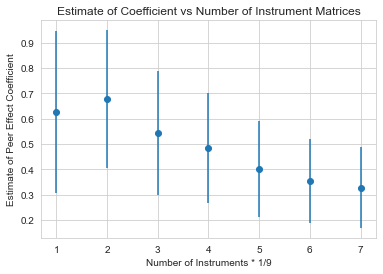

In [30]:
# Initialize lists to store estimates and standard errors
estimates = []
std_errors = []

# Add a column of ones to X for the constant term
X_with_const = np.column_stack((np.ones(X.shape[0]), X))
inst_vec = [AX, A2X, A3X, A4X, A5X, A6X, A7X]

# Loop over the number of instruments
for num_instruments in range(1,8):
    # Get the instruments
    inst = np.column_stack([i for i in inst_vec[0:num_instruments]])
    print(len(inst[0]))
    # Fit the IV2SLS model with the constant term
    model = IV2SLS(dependent=y, exog=X_with_const, endog=Ay, instruments=inst).fit()

    # Append estimates and standard errors to the lists
    estimates.append(model.params[-1])  # The coefficient of X
    std_errors.append(model.std_errors[-1])  # The standard error of the coefficient of X

# Plot the evolution of the endogenous estimate with standard error depending on the number of instruments
plt.errorbar(range(1, 8), estimates, yerr=std_errors, fmt='o')
plt.xticks(range(1, 8))
plt.xlabel('Number of Instruments * 1/9')
plt.ylabel('Estimate of Peer Effect Coefficient')
plt.title('Estimate of Coefficient vs Number of Instrument Matrices')
plt.show()


I.e. the true parameter seems to be slightly larger than assumed in question 1

## e) Global effect
Since the schools have different sizes, identification is possible.

In [31]:
A_vec = []
X_vec =  pd.DataFrame(columns=X_col)
y_vec = []
AX_vec = []
A2X_vec = []
Ay_vec = []

for school in schools:
    # Select correct students
    G = create_graph(df2, school)
    GC = giant_component(G)
    if GC is None:
        print("Not enough answers in school:",school)
        continue
    data = df2[df2['id'].isin(GC.nodes())]
    
    # Create target vector
    y = np.array(data['socs'])
    y_vec.append(y)

    # Create correct feature matrix
    X = data[X_col]
    X_vec = pd.concat([X_vec, X], ignore_index=False)
    
    # For block matrix
    A = nx.to_numpy_array(GC)
    A = A / A.sum(axis=1, keepdims=True)
    A_vec.append(csr_matrix(A))

    # Compute higher order matrices 
    # (could also just do matrix multiplication with the entire block matrix instead)
    Ay = A.dot(y)
    Ay_vec.append(Ay)
    AX = A.dot(X)
    AX_vec.append(AX)
    A2X = A.dot(AX)
    A2X_vec.append(A2X)
    
y = np.concatenate(y_vec)
A = block_diag_sparse(A_vec)
X = X_vec
Ay = np.concatenate(Ay_vec)
AX = np.concatenate(AX_vec)
A2X = np.concatenate(A2X_vec)

print(len(y), A.shape, X.shape, len(Ay), (len(AX), len(AX[0])), (len(A2X), len(A2X[0])))

Not enough answers in school: 175
74974 (74974, 74974) (74974, 9) 74974 (74974, 9) (74974, 9)


In [32]:
# Alternative way
# AX = A@X
# A2X = A@AX
A3X = A@A2X

In [33]:
# Add a column of ones to X for the constant term
X_with_const = np.column_stack((np.ones(X.shape[0]), X))
inst = np.column_stack((AX, A2X)) # Can use several instruments
# inst = AX # or just one

# Fit the IV2SLS model with the constant term
model = IV2SLS(dependent=y, exog=X_with_const, endog=Ay, instruments=inst).fit()

# Print model summary
print(model.summary)
print("Model is overidentified:", model.model.instruments.shape[1]>model.model.dependent.shape[1])

                          IV-2SLS Estimation Summary                          
Dep. Variable:              dependent   R-squared:                      0.0327
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0326
No. Observations:               74974   F-statistic:                    2959.7
Date:                Thu, May 02 2024   P-value (F-stat)                0.0000
Time:                        22:46:43   Distribution:                 chi2(10)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
exog.0         0.5026     0.0802     6.2641     0.0000      0.3453      0.6598
exog.1        -0.0307     0.0034    -9.0446     0.00

In [34]:
#print(model.summary.as_latex())

## f) School Fixed Effects

Since the classes have different sizes, identification can be obtained

In [35]:
I = eye_sparse(A.shape[0], format='csr')
y_fe = (I-A)@y
X_fe = (I-A)@X
AX_fe = (I-A)@(A@X)
Ay_fe = (I-A)@(A@y)
A2X_fe = (I-A)@(A@(A@X))

In [36]:
# Add a column of ones to X for the constant term
X_with_const = np.column_stack((np.ones(X_fe.shape[0]), X_fe))
inst = np.column_stack((AX_fe, A2X_fe)) # Can use several instruments
#inst = AX_fe # or just one

# Fit the IV2SLS model with the constant term
model = IV2SLS(dependent=y_fe, exog=X_with_const, endog=Ay_fe, instruments=inst).fit()

# Print model summary
print(model.summary)
print("Model is overidentified:", model.model.instruments.shape[1]>model.model.dependent.shape[1])

                          IV-2SLS Estimation Summary                          
Dep. Variable:              dependent   R-squared:                     -0.0565
Estimator:                    IV-2SLS   Adj. R-squared:                -0.0567
No. Observations:               74974   F-statistic:                    697.02
Date:                Thu, May 02 2024   P-value (F-stat)                0.0000
Time:                        22:46:44   Distribution:                 chi2(10)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
exog.0        -0.0388     0.0057    -6.8425     0.0000     -0.0499     -0.0277
exog.1        -0.0338     0.0050    -6.6983     0.00

In [37]:
# print(model.summary.as_latex())